# Automatically Group Data and Find Correlations using Maximal Information Coeffecient

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mictools as mic
from minepy import MINE

## Group Data
- groupData groups together columns in a pandas dataframe with the same value.
- The output of the function is a dictionary that can later be converted into a dataframe and be outputted to a csv etc.
- Arguements are the name of the column to base the grouping upon and the pandas dataframe with the ungrouped data.
- markRepeats is intended to mark redundant relationships to clean up the output in the example

In [377]:
#Converts a pandas dataframe into a dictionary 
#Groups together data entries with like markers
def groupData(marker, raw_data):
    grouped_data = dict()
    raw_data.reset_index()
    for index, row in raw_data.iterrows():
        entry = dict()
        marker_value = None
        
        for column in raw_data.columns:
            if column != marker:
                entry[column] = row[column]
            else:
                marker_value = row[column]
        if marker_value not in grouped_data.keys():
            grouped_data[marker_value] = np.array([])
        grouped_data[marker_value] = np.append(grouped_data[marker_value], entry)
    return grouped_data

#Mark repeated relationships in a pandas dataframe e.g. A|B vs B|A
def markRepeats(data):
    pairs = []
    for row in data.index:
        for column in data.columns:
            pair = {row,column}
            if pair in pairs:
                data[column][row] = 0
            else:
                pairs.append(pair)
    return data

## Correllation Matrix
- This function generates a correllation matrix for a pandas dataframe
- The output of the function is a pandas dataframe.
- The arguement is the pandas dataframe with the raw data
- The method used is MIC (maximal information coeffecient) which applies information theory and probability to find non-linear correllations.
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3325791/

In [378]:
def corr(data):
    correllations = pd.DataFrame(index=data.columns, columns=data.columns, dtype="float") 
    for column in correllations.columns:
        for row in correllations.index:
            mine = MINE(alpha=0.6, c=len(correllations.index), est="mic_e") #bx*c <= bmax = N^alpha
            mine.compute_score(data[row], data[column])
            correllations[row][column] = np.around(mine.mic(), 1)
    return correllations

## Example

In [379]:
#Load example data and group together entries with like markers

#Cars data example
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_car_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
sample_data = raw_car_dataset.copy().dropna()

#Data grouping example
marker = "Model Year"
workable_data = groupData(marker, sample_data)
d = {'Rows (original)' : sample_data.shape[0],
    'Rows (after grouping)' : len(workable_data.keys()),
    'Duplicates' : sample_data.shape[0] - len(workable_data.keys())
    }
print(pd.DataFrame(data = d, index=[0]).transpose())

                         0
Rows (original)        392
Rows (after grouping)   13
Duplicates             379


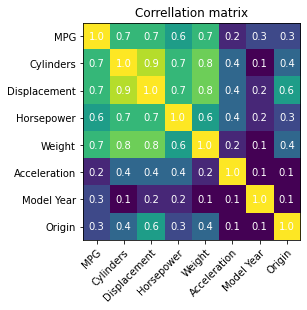

Displacement  Cylinders       0.9
Weight        Cylinders       0.8
              Displacement    0.8
Cylinders     MPG             0.7
Displacement  MPG             0.7
Horsepower    Cylinders       0.7
              Displacement    0.7
Weight        MPG             0.7
Origin        Displacement    0.6
Horsepower    MPG             0.6
dtype: float64


In [380]:
#Find correlation matrix of data entries
correllations = corr(pd.get_dummies(sample_data))

#Plot correlation matrix
fig, ax = plt.subplots()
im = plt.imshow(correllations)
ax.set_xticks(np.arange(len(correllations.columns)), labels=correllations.columns)
ax.set_yticks(np.arange(len(correllations.index)), labels=correllations.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(len(correllations.index)):
    for j in range(len(correllations.columns)):
        text = ax.text(j, i, correllations[correllations.columns[j]][correllations.index[i]],
                       ha="center", va="center", color="w")
ax.set_title("Correllation matrix")
plt.show()

#Find the most correlated pairs of data
NUM_PAIRS = 10 #number of correlated pairs to output
pairs = markRepeats(correllations).unstack() #remove repeats e.g. A|B vs B|A
filter = [pair != 1 and pair > 0 for pair in pairs] #remove self correllations
sorted_pairs = pairs[filter].sort_values(kind="quicksort").iloc[::-1]
print(sorted_pairs[:NUM_PAIRS])

The output from this example can then be used to guide further analysis and potential machine learning applications. 